# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def updating_parameter_scan(s, name, values, y0):
    y0 = y0.copy()
    conc = {}
    flux = {}
    for value in tqdm(values, total=len(values)):
        s.clear_results()
        s.initialise(y0)
        s.update_parameter(name, value)
        try:
            t, y = s.simulate(100_000)
            conc[value] = dict(s.get_full_results_df().iloc[-1])
            flux[value] = dict(s.model.get_fluxes_df(y[-1]).iloc[-1])
            y0 = get_new_y0(s)
        except:
            break
    return pd.DataFrame(conc).T, pd.DataFrame(flux).T


def compartmentalise_groups(base_groups: list[str]) -> list[str]:
    groups = []
    for group in base_groups:
        groups.append([f"{i}_meso" for i in group])
        groups.append([f"{i}_bs" for i in group])
    return groups


def is_steady(v, cpd):
    return np.isclose(
        sum(
            v.iloc[-1][k] * val for k, val in m.stoichiometries_by_compounds[cpd].items()
        ),
        0,
    )


def plot_reactions_of_cpd(v, cpd, ax=None):
    rxns = v.loc[:, list(m.stoichiometries_by_compounds[cpd])]
    return rxns.plot(ax=ax, ylim=(np.min(rxns.values) * 0.9, np.max(rxns.values) * 1.1))


def plot_cpd_rhs(v, cpd, ax=None):
    return (
        pd.DataFrame(v[k] * val for k, val in m.stoichiometries_by_compounds[cpd].items())
        .sum()
        .plot(ax=ax, label=cpd)
    )


STEADY_STATE_CONCENTRATIONS = {}
STEADY_STATE_FLUXES = {}

# Base models

## Poolman 2000

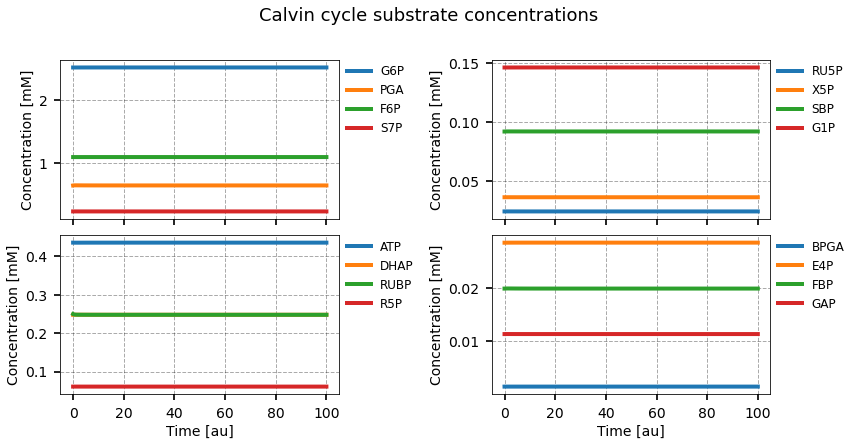

In [2]:
y0_poolman = {
    "PGA": 0.6437280277346407,
    "BPGA": 0.001360476366780556,
    "GAP": 0.011274125311289358,
    "DHAP": 0.24803073890728228,
    "FBP": 0.019853938009873073,
    "F6P": 1.0950701164493861,
    "G6P": 2.5186612678035734,
    "G1P": 0.14608235353185037,
    "SBP": 0.09193353265673603,
    "S7P": 0.23124426886012006,
    "E4P": 0.028511831060903877,
    "X5P": 0.036372985623662736,
    "R5P": 0.06092475016463224,
    "RUBP": 0.24993009253928708,
    "RU5P": 0.02436989993734177,
    "ATP": 0.43604115800259613,
}

m = models.get_poolman()
s = Simulator(m)
s.initialise(y0_poolman)
t, y = s.simulate(100)
groups = [
    ["G6P", "PGA", "F6P", "S7P"],
    ["RU5P", "X5P", "SBP", "G1P"],
    ["ATP", "DHAP", "RUBP", "R5P"],
    ["BPGA", "E4P", "FBP", "GAP"],
]

s.plot_grid(
    compound_groups=groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="Concentration [mM]",
    figure_title="Calvin cycle substrate concentrations",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (12, 6)},
)
plt.show()

STEADY_STATE_CONCENTRATIONS["poolman"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["poolman"] = dict(s.get_fluxes_df().iloc[-1])

## Yokota 1985

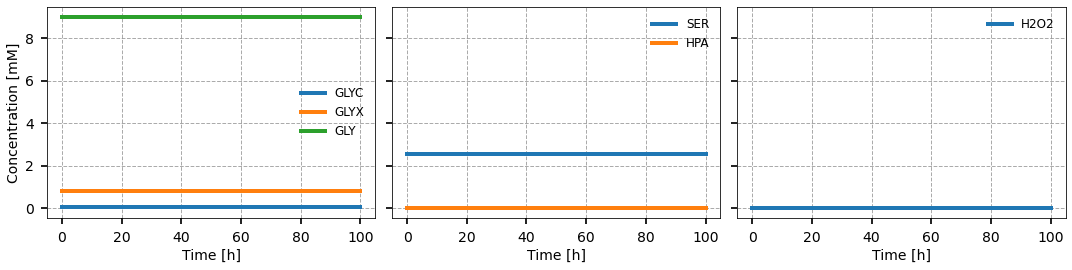

In [3]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

m = models.get_yokota()
s = Simulator(m)
s.initialise(y0_yokota)
t, y = s.simulate(100)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX", "GLY"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
)
fig.tight_layout()
plt.show()

STEADY_STATE_CONCENTRATIONS["yokota"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["yokota"] = dict(s.get_fluxes_df().iloc[-1])

## Matuszynska 2016

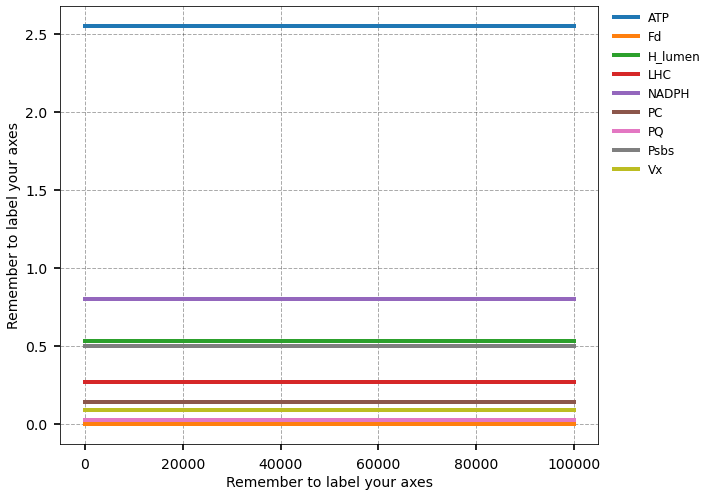

In [4]:
y0 = {
    "ATP": 2.549999999990209,
    "Fd": 4.532178467059945e-06,
    "H_lumen": 0.5348093494341077,
    "LHC": 0.27084383051851296,
    "NADPH": 0.799999999999999,
    "PC": 0.14270705226940816,
    "PQ": 0.02551779468550671,
    "Psbs": 0.5000004164114361,
    "Vx": 0.09090909092843401,
}

m = models.get_matuszynska()
m.update_parameters(
    {
        "pfd": 700,
    },
)
s = Simulator(m)
s.initialise(y0)
s.simulate(100_000)
s.plot()

STEADY_STATE_CONCENTRATIONS["matuszynska"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["matuszynska"] = dict(s.get_fluxes_df().iloc[-1])

## Poolman-Yokota

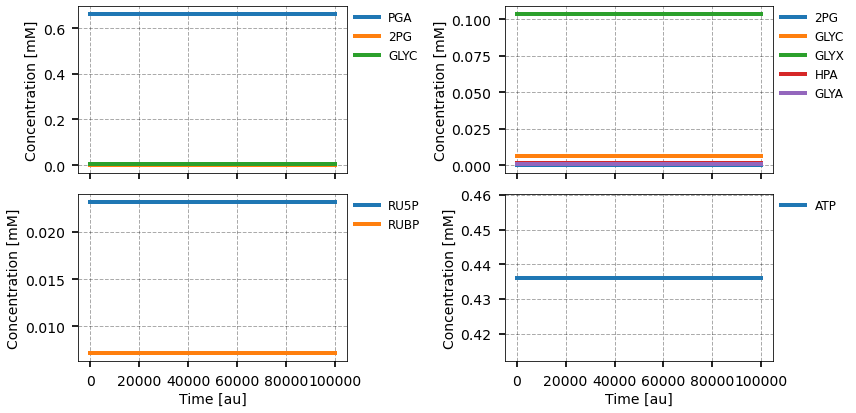

In [5]:
y0 = {
    "PGA": 0.6624561686534526,
    "BPGA": 0.0014027993404828374,
    "GAP": 0.01129179440921104,
    "DHAP": 0.24841945921795988,
    "FBP": 0.019916217999737286,
    "F6P": 1.0718206480146921,
    "G6P": 2.465187490405272,
    "G1P": 0.1429808744427866,
    "SBP": 0.09494604378844229,
    "S7P": 0.20867279493403046,
    "E4P": 0.029400040457721866,
    "X5P": 0.034579318355853796,
    "R5P": 0.057920357490264016,
    "RUBP": 0.007161207547558802,
    "RU5P": 0.023168142867460315,
    "ATP": 0.43615022291213246,
    "GLYC": 0.0063392995940245115,
    "GLYX": 0.10370131957211849,
    "GLY": 0.633929959402451,
    "SER": 1.054605046564468,
    "HPA": 0.0014580881074988095,
    "H2O2": 0.0017327699183872975,
    "2PG": 1.8182025661231184e-06,
    "GLYA": 0.0009575260898819255,
}

m = models.get_poolman_yokota()
m.update_parameter("O2", 0.1)


s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(100_000)
groups = [
    ["PGA", "2PG", "GLYC"],
    ["2PG", "GLYC", "GLYX", "HPA", "GLYA"],  # "GLY",
    ["RU5P", "RUBP"],
    [
        "ATP",
    ],
    #         ["G6P", "F6P", "S7P"],
    #         ["RU5P", "X5P", "SBP", "G1P"],
    #         ["ATP", "DHAP", "RUBP", "R5P"],
    #         ["BPGA", "E4P", "FBP", "GAP"],
    #         ["GLYC", "GLYX", "GLY", "HPA", "GLYA"],
    #         ["SER"],
    #         ["H2O2"],
]
fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="Concentration [mM]",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (12, len(groups) // 2 * 3)},
)


STEADY_STATE_CONCENTRATIONS["poolman-yokota"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["poolman-yokota"] = dict(s.get_fluxes_df().iloc[-1])

## Poolman-Matuszynska

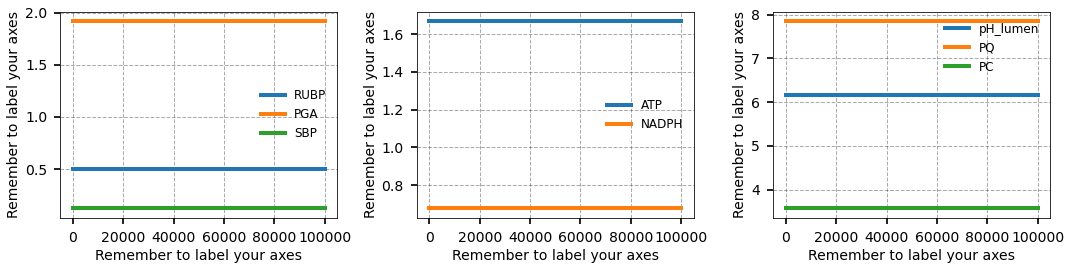

In [6]:
y0 = {
    "PGA": 1.9178474673930037,
    "BPGA": 0.001126030851308874,
    "GAP": 0.01419892968741602,
    "DHAP": 0.3123763702284208,
    "FBP": 0.03149139732338604,
    "F6P": 1.4172343194902335,
    "G6P": 3.259638933673801,
    "G1P": 0.18905905812398624,
    "SBP": 0.12280438617553915,
    "S7P": 0.43361926280180507,
    "E4P": 0.030240740613414786,
    "X5P": 0.055896433561919805,
    "R5P": 0.09362652259359767,
    "RUBP": 0.5053857070932402,
    "RU5P": 0.037450608420823234,
    "PQ": 7.852407481671385,
    "PC": 3.5672976029022188,
    "Fd": 1.8314816990065979,
    "ATP": 1.6688593958416371,
    "NADPH": 0.6766534448762497,
    "H_lumen": 0.0027584492794532726,
    "LHC": 0.6914544081007563,
    "Psbs": 0.9292739274740575,
    "Vx": 0.8668747992499402,
    "TR_ox": 0.7063144982137682,
    "E_inactive": 1.5240591722979024,
    "MDA": 9.222559577655867e-06,
    "H2O2": 5.456376204580775e-06,
    "DHA": 2.1140585906857025e-08,
    "GSSG": 1.0256027698377096e-08,
}

m = models.get_poolman_matuszynska()
m.update_parameters(
    {
        "pfd": 700,
    },
)
s = Simulator(m)
s.initialise(y0)
s.simulate(100_000)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
    ],
    sharey=False,
)

STEADY_STATE_CONCENTRATIONS["poolman-matuszynska"] = dict(
    s.get_full_results_df().iloc[-1]
)
STEADY_STATE_FLUXES["poolman-matuszynska"] = dict(s.get_fluxes_df().iloc[-1])

## PMY

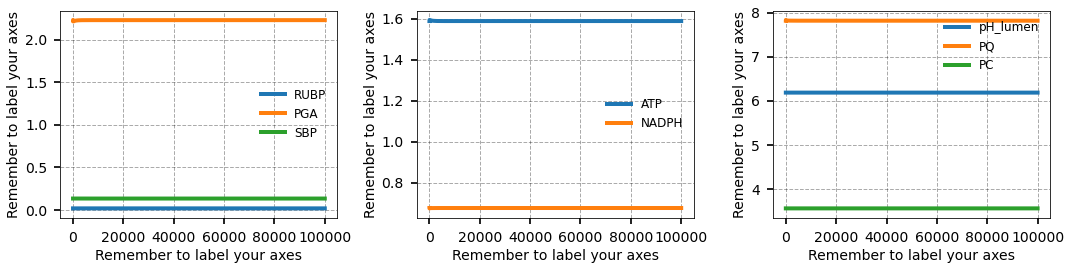

In [7]:
y0 = {
    "PGA": 2.2276485103437427,
    "BPGA": 0.0011395114513427407,
    "GAP": 0.01437728387563096,
    "DHAP": 0.3163001624241285,
    "FBP": 0.032287499768383056,
    "F6P": 1.4342864448822685,
    "G6P": 3.298858822091134,
    "G1P": 0.1913338116525863,
    "SBP": 0.13353907144554278,
    "S7P": 0.3899166942978721,
    "E4P": 0.03247623313858873,
    "X5P": 0.05333672491952933,
    "R5P": 0.08933901059391576,
    "RUBP": 0.018198635586326027,
    "RU5P": 0.0357356036169202,
    "PQ": 7.816523427167374,
    "PC": 3.565501172034674,
    "Fd": 1.8291234258850684,
    "ATP": 1.5877722563236283,
    "NADPH": 0.6762996535196552,
    "H_lumen": 0.002596786328670221,
    "LHC": 0.6898228247114043,
    "Psbs": 0.9395780584648848,
    "Vx": 0.8976667214449721,
    "TR_ox": 0.7059882075494811,
    "E_inactive": 1.5227970621594624,
    "MDA": 0.00010652352820034591,
    "DHA": 2.820446578139989e-06,
    "GSSG": 1.368268354693092e-06,
    "GLYC": 0.014778266510847009,
    "GLYX": 0.2226899362040231,
    "GLY": 11.98208982962587,
    "SER": 1.3149573123625822,
    "HPA": 0.003055166517287168,
    "H2O2": 5.898558840438341e-05,
    "2PG": 3.760529997517723e-06,
    "GLYA": 0.005018355275948738,
}

m = models.get_pmy()
m.update_parameters(
    {
        "pfd": 700,
        "O2": 0.1,
    },
)
s = Simulator(m)
s.initialise(y0)
s.simulate(100_000)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
    ],
    sharey=False,
)

STEADY_STATE_CONCENTRATIONS["pmy"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["pmy"] = dict(s.get_fluxes_df().iloc[-1])

## C3 wildtype

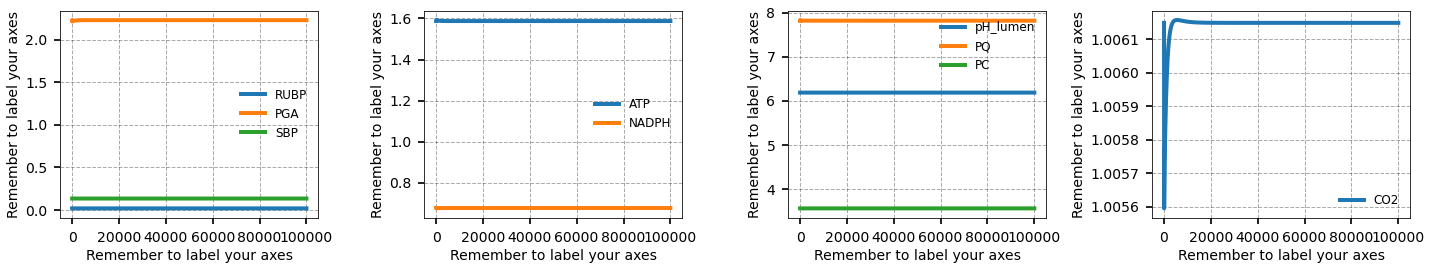

In [8]:
y0 = {
    "PGA": 2.2287343471797025,
    "BPGA": 0.0011395172052077096,
    "GAP": 0.014377954709777471,
    "DHAP": 0.3163149207717971,
    "FBP": 0.032290512863973456,
    "F6P": 1.434383829657654,
    "G6P": 3.2990828070742633,
    "G1P": 0.1913468027816013,
    "SBP": 0.13354114459656463,
    "S7P": 0.39001212495296217,
    "E4P": 0.03247522205016537,
    "X5P": 0.05334449596935596,
    "R5P": 0.08935202710230132,
    "RUBP": 0.018002483554901912,
    "RU5P": 0.03574081022026182,
    "PQ": 7.816317812506009,
    "PC": 3.5654905892762097,
    "Fd": 1.8290228379937157,
    "ATP": 1.5874832946831252,
    "NADPH": 0.6763120766939782,
    "H_lumen": 0.002596276070658352,
    "LHC": 0.6898134476997627,
    "Psbs": 0.9396093683256888,
    "Vx": 0.8977559187171258,
    "TR_ox": 0.7059742923607198,
    "E_inactive": 1.5227432839210808,
    "MDA": 0.00010516387564256525,
    "DHA": 2.7489043868837883e-06,
    "GSSG": 1.3335621272814589e-06,
    "GLYC": 0.014538274163153227,
    "GLYX": 0.21956585389101793,
    "GLY": 11.927538736898514,
    "SER": 1.3081512965652184,
    "HPA": 0.003014225861699743,
    "H2O2": 5.828488769550733e-05,
    "2PG": 3.711365630597338e-06,
    "GLYA": 0.004954584293738558,
    "CO2": 1.0061496713299651,
    "HCO3": 50.30748356649821,
}

m = models.get_c3_mesophyll()

SHARED_PAR_UPDATES = {
    "pfd": 700,
    "O2": 0.1,
    "CO2_ext": 2,
    "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
}
m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0)
s.simulate(100_000)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
        ["CO2"],
    ],
    sharey=False,
)

STEADY_STATE_CONCENTRATIONS["wildtype"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES["wildtype"] = dict(s.get_fluxes_df().iloc[-1])

## Comparison

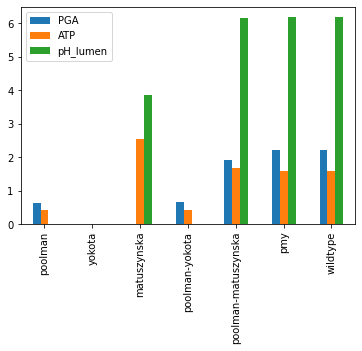

In [9]:
df = pd.DataFrame(STEADY_STATE_CONCENTRATIONS).T
df.loc[:, ["PGA", "ATP", "pH_lumen"]].plot(kind="bar")
plt.show()

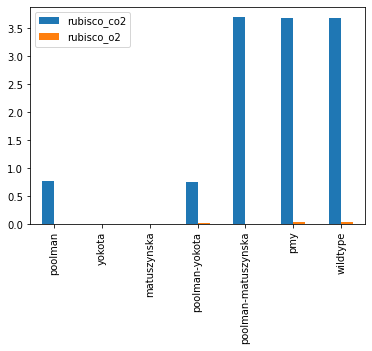

In [10]:
df = pd.DataFrame(STEADY_STATE_FLUXES).T
df.loc[:, ["rubisco_co2", "rubisco_o2"]].plot(kind="bar")
plt.show()

# Two-compartment models

In [11]:
STEADY_STATE_CONCS_2C = {}
STEADY_STATE_FLUXES_2C = {}

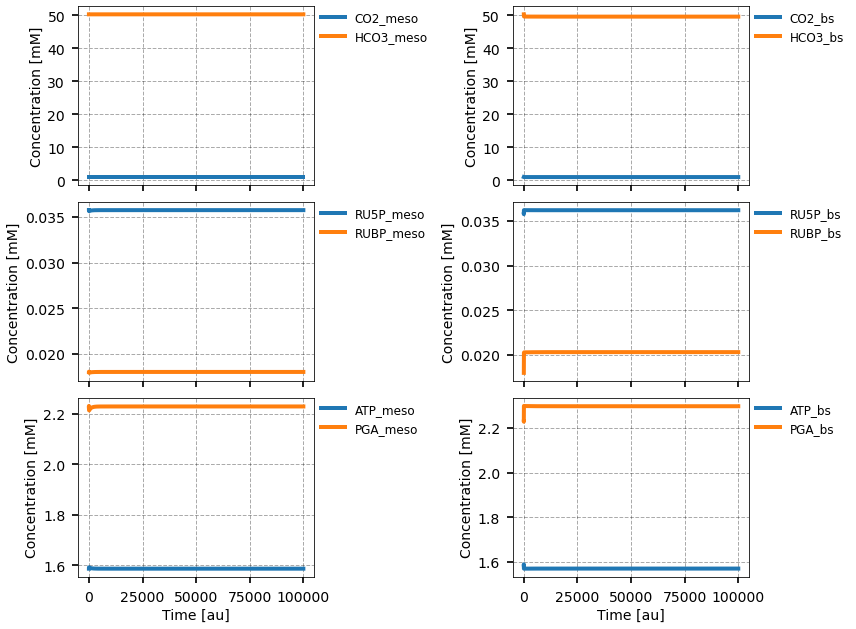

In [12]:
y0_2c = {f"{k}_meso": v for k, v in y0.items()} | {f"{k}_bs": v for k, v in y0.items()}

m = models.get_two_compartment_model()
m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0_2c)
t, y = s.simulate(100_000)
base_groups = [["CO2", "HCO3"], ["RU5P", "RUBP"], ["ATP", "PGA"]]
groups = compartmentalise_groups(base_groups)
fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="Concentration [mM]",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (12, 3 * len(groups) // 2)},
)

STEADY_STATE_CONCS_2C["wildtype"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES_2C["wildtype"] = dict(s.get_fluxes_df().iloc[-1])

## GDC reroute

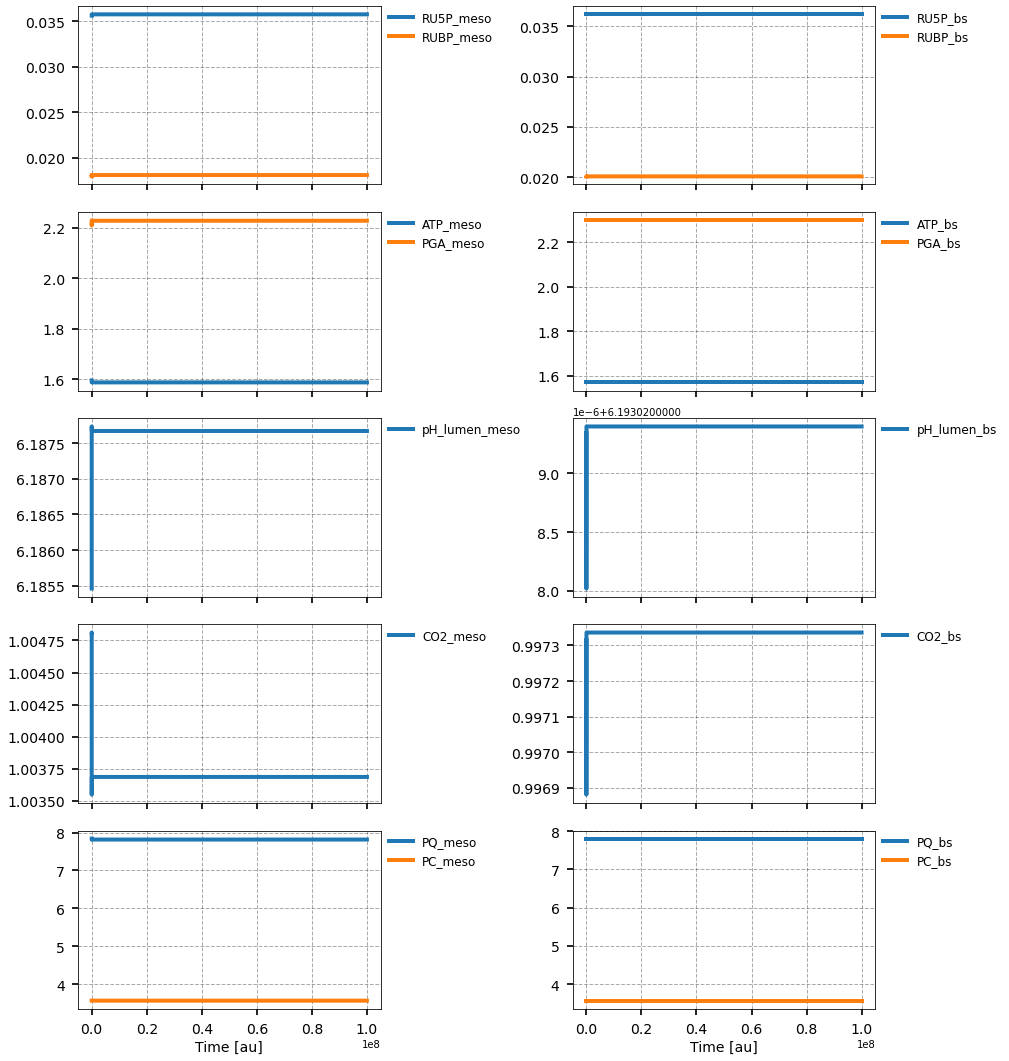

In [13]:
y0_gdc = {
    "PGA_meso": 2.213153174306171,
    "BPGA_meso": 0.001146476133448358,
    "GAP_meso": 0.014405025011670578,
    "DHAP_meso": 0.3169104674883144,
    "FBP_meso": 0.03241221828155178,
    "F6P_meso": 1.4392654663331423,
    "G6P_meso": 3.310310571429149,
    "G1P_meso": 0.1919980131142165,
    "SBP_meso": 0.13505539640668346,
    "S7P_meso": 0.3860878921500455,
    "E4P_meso": 0.03278174520026857,
    "X5P_meso": 0.053125386785103465,
    "R5P_meso": 0.0889850192229432,
    "RUBP_meso": 0.017972308056895724,
    "RU5P_meso": 0.035594007069244496,
    "PQ_meso": 7.84066154493485,
    "PC_meso": 3.566782758853627,
    "Fd_meso": 1.8516296363202263,
    "ATP_meso": 1.5953225680084735,
    "NADPH_meso": 0.6730280501875725,
    "H_lumen_meso": 0.0026097704965641916,
    "LHC_meso": 0.6909214132263446,
    "Psbs_meso": 0.9387787046031782,
    "Vx_meso": 0.8953800122767518,
    "TR_ox_meso": 0.7091060384327204,
    "E_inactive_meso": 1.5349431277841052,
    "MDA_meso": 0.00010509225903038937,
    "DHA_meso": 2.745161545838292e-06,
    "GSSG_meso": 1.3317751195838502e-06,
    "GLYC_meso": 0.014554230505661183,
    "GLYX_meso": 0.2197740000523597,
    "GLY_meso": 16.194641412541376,
    "SER_meso": 1.3086048058124222,
    "HPA_meso": 0.0030169552099727714,
    "H2O2_meso": 5.8238593562169786e-05,
    "2PG_meso": 3.714644233515353e-06,
    "GLYA_meso": 0.00492911741685447,
    "CO2_meso": 1.0048111161768907,
    "HCO3_meso": 50.24055580884454,
    "ATP_bs": 1.5691493821388836,
    "BPGA_bs": 0.0011394931362231663,
    "CO2_bs": 0.9973142577257728,
    "DHAP_bs": 0.31726546494935903,
    "DHA_bs": 2.138111416290994e-08,
    "E4P_bs": 0.032323149455365706,
    "E_inactive_bs": 1.5189094784792319,
    "F6P_bs": 1.4410271299556698,
    "FBP_bs": 0.03248487409893125,
    "Fd_bs": 1.821830333777888,
    "G1P_bs": 0.19223301903974913,
    "G6P_bs": 3.314362397740383,
    "GAP_bs": 0.01442116127511464,
    "GSSG_bs": 1.037267803832183e-08,
    "H2O2_bs": 5.487277087269266e-06,
    "HCO3_bs": 49.865712886288634,
    "H_lumen_bs": 0.002564665028320001,
    "LHC_bs": 0.6891888987453474,
    "MDA_bs": 9.274876283917347e-06,
    "NADPH_bs": 0.6772184183343841,
    "PC_bs": 3.56478523380339,
    "PGA_bs": 2.2976750091264537,
    "PQ_bs": 7.80263876803395,
    "Psbs_bs": 0.9415336741905005,
    "R5P_bs": 0.09045920530401283,
    "RU5P_bs": 0.03618368150016577,
    "RUBP_bs": 0.02009116651008473,
    "S7P_bs": 0.39853980166048564,
    "SBP_bs": 0.13331522733081566,
    "TR_ox_bs": 0.7049797512615865,
    "Vx_bs": 0.9031836254816247,
    "X5P_bs": 0.05400549788356363,
}

m = models.get_gdc_reroute()
m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0_gdc)
t, y = s.simulate(100_000_000)
base_groups = [["RU5P", "RUBP"], ["ATP", "PGA"], ["pH_lumen"], ["CO2"], ["PQ", "PC"]]
groups = compartmentalise_groups(base_groups)

fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (14, len(groups) // 2 * 3)},
)
plt.show()

STEADY_STATE_CONCS_2C["gdc-reroute"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES_2C["gdc-reroute"] = dict(s.get_fluxes_df().iloc[-1])

## TaCo shunt

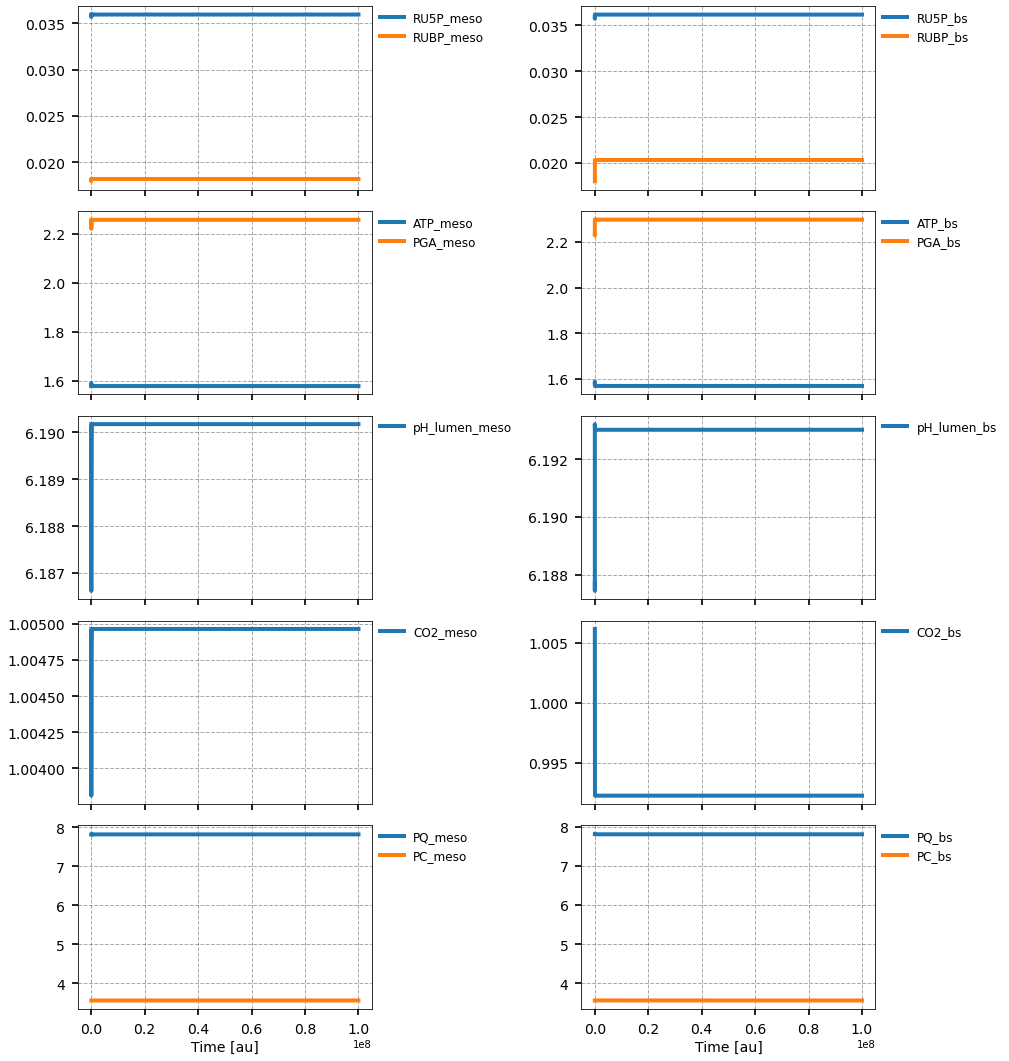

In [14]:
y0_taco = {
    "PGA_meso": 2.2561928980545893,
    "BPGA_meso": 0.001137549307022942,
    "GAP_meso": 0.01434852801996602,
    "DHAP_meso": 0.31566753372830475,
    "FBP_meso": 0.03215847309949096,
    "F6P_meso": 1.4278894893879452,
    "G6P_meso": 3.284145824452903,
    "G1P_meso": 0.1904804577895364,
    "SBP_meso": 0.13171298549865945,
    "S7P_meso": 0.3948573762677876,
    "E4P_meso": 0.032096331049801294,
    "X5P_meso": 0.053619876503716885,
    "R5P_meso": 0.08981328950372502,
    "RUBP_meso": 0.01820120768321621,
    "RU5P_meso": 0.03592531518191542,
    "PQ_meso": 7.812190773160753,
    "PC_meso": 3.5652819037949985,
    "Fd_meso": 1.8280270127057905,
    "ATP_meso": 1.5790960920964712,
    "NADPH_meso": 0.6763916455668818,
    "H_lumen_meso": 0.0025815832279617416,
    "LHC_meso": 0.6896251674236891,
    "Psbs_meso": 0.9405075600936412,
    "Vx_meso": 0.9003027496841436,
    "TR_ox_meso": 0.7058365408029205,
    "E_inactive_meso": 1.522211118255899,
    "MDA_meso": 8.161593046636795e-05,
    "DHA_meso": 1.6556608367601603e-06,
    "GSSG_meso": 8.032090301084248e-07,
    "GLYC_meso": 0.01055197906649359,
    "GLYX_meso": 0.16554142457212553,
    "GLY_meso": 42.84448128342466,
    "SER_meso": 1.1902035834912295,
    "HPA_meso": 0.00229789744993714,
    "H2O2_meso": 4.59467671839985e-05,
    "2PG_meso": 3.7395703326620385e-06,
    "GLYA_meso": 0.006256738658225091,
    "CO2_meso": 1.00496415321724,
    "HCO3_meso": 50.24370926198994,
    "2PG_bs": 3.711365630561523e-06,
    "ATP_bs": 1.5874832946823536,
    "BPGA_bs": 0.0011395172052077668,
    "CO2_bs": 1.0061496713328162,
    "DHAP_bs": 0.31631492077112205,
    "DHA_bs": 2.7489043868278134e-06,
    "E4P_bs": 0.03247522204994107,
    "E_inactive_bs": 1.5227432839282995,
    "F6P_bs": 1.434383829651333,
    "FBP_bs": 0.03229051286383609,
    "Fd_bs": 1.829022838007017,
    "G1P_bs": 0.19134680278075805,
    "G6P_bs": 3.2990828070597242,
    "GAP_bs": 0.014377954709746787,
    "GLYA_bs": 0.004954584293529038,
    "GLYC_bs": 0.014538274162979906,
    "GLYX_bs": 0.21956585389678573,
    "GLY_bs": 54.50404171650197,
    "GSSG_bs": 1.3335621272543119e-06,
    "H2O2_bs": 5.8284887694943404e-05,
    "HCO3_bs": 50.30748356664081,
    "HPA_bs": 0.0030142258615661983,
    "H_lumen_bs": 0.002596276070654389,
    "LHC_bs": 0.6898134477022986,
    "MDA_bs": 0.00010516387564148122,
    "NADPH_bs": 0.6763120766926163,
    "PC_bs": 3.5654905892778146,
    "PGA_bs": 2.228734347182705,
    "PQ_bs": 7.816317812545448,
    "Psbs_bs": 0.9396093683259317,
    "R5P_bs": 0.08935202710233903,
    "RU5P_bs": 0.035740810220276906,
    "RUBP_bs": 0.018002483554731556,
    "S7P_bs": 0.39001212495413645,
    "SBP_bs": 0.13354114459536415,
    "SER_bs": 1.3081512964720503,
    "TR_ox_bs": 0.7059742923625649,
    "Vx_bs": 0.8977559186623455,
    "X5P_bs": 0.05334449596937848,
    "glycolyl_coa_meso": 0.00024162740313295818,
    "tartronyl_coa_meso": 0.00019590878526274912,
    "tartronate_semialdehyde_meso": 1.4810902677439227e-05,
}

m = models.get_taco_shunt()
m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0_taco)
t, y = s.simulate(100_000_000)

base_groups = [["RU5P", "RUBP"], ["ATP", "PGA"], ["pH_lumen"], ["CO2"], ["PQ", "PC"]]
groups = compartmentalise_groups(base_groups)
fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (14, len(groups) // 2 * 3)},
)
plt.show()

STEADY_STATE_CONCS_2C["taco"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES_2C["taco"] = dict(s.get_fluxes_df().iloc[-1])

## THF Bypass

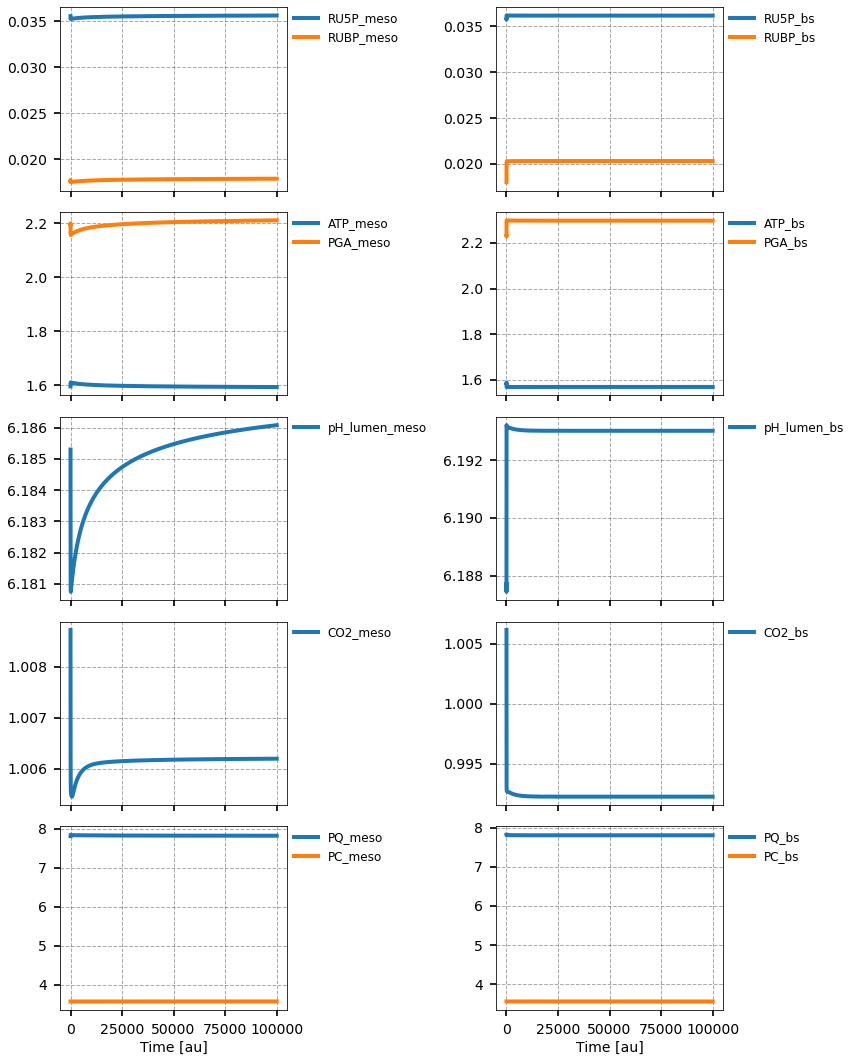

In [15]:
y0_thf = {
    "PGA_meso": 2.1966803430492328,
    "BPGA_meso": 0.0011381134452505342,
    "GAP_meso": 0.014391397608048308,
    "DHAP_meso": 0.3166106643788379,
    "FBP_meso": 0.032350922154084555,
    "F6P_meso": 1.4383729484905035,
    "G6P_meso": 3.3082577803929016,
    "G1P_meso": 0.19187895123416016,
    "SBP_meso": 0.13488480759922536,
    "S7P_meso": 0.385489063022025,
    "E4P_meso": 0.032771340808987,
    "X5P_meso": 0.053059056336850624,
    "R5P_meso": 0.08887391570901453,
    "RUBP_meso": 0.01768326360251917,
    "RU5P_meso": 0.03554956566144235,
    "PQ_meso": 7.809997418594457,
    "PC_meso": 3.5651406181213035,
    "Fd_meso": 1.8190830785653795,
    "ATP_meso": 1.5954121564590464,
    "NADPH_meso": 0.6778219349891208,
    "H_lumen_meso": 0.0026107250117369278,
    "LHC_meso": 0.6895250515204605,
    "Psbs_meso": 0.9387197415046932,
    "Vx_meso": 0.8952106216764804,
    "TR_ox_meso": 0.7046001168145543,
    "E_inactive_meso": 1.5174511311591279,
    "MDA_meso": 0.00010382849164815813,
    "DHA_meso": 2.6795338222797763e-06,
    "GSSG_meso": 1.2998966716302922e-06,
    "GLYC_meso": 0.014290713214002703,
    "GLYX_meso": 0.31587294277075356,
    "GLY_meso": 69.98350523416116,
    "SER_meso": 0.551483100503152,
    "HPA_meso": 0.0017168496885263285,
    "H2O2_meso": 5.75996578316073e-05,
    "2PG_meso": 3.6603181208063495e-06,
    "GLYA_meso": 0.0028122720438023435,
    "CO2_meso": 1.0087189734915505,
    "HCO3_meso": 50.43594867457635,
    "2PG_bs": 3.71136563287684e-06,
    "ATP_bs": 1.5874832947704234,
    "BPGA_bs": 0.0011395172052093392,
    "CO2_bs": 1.0061496711389524,
    "DHAP_bs": 0.31631492081700335,
    "DHA_bs": 2.7489043904925557e-06,
    "E4P_bs": 0.03247522206620494,
    "E_inactive_bs": 1.5227432834545398,
    "F6P_bs": 1.4343838300852059,
    "FBP_bs": 0.03229051287320299,
    "Fd_bs": 1.8290228371214499,
    "G1P_bs": 0.19134680283863675,
    "G6P_bs": 3.2990828080576327,
    "GAP_bs": 0.014377954711832302,
    "GLYA_bs": 0.004954584301048482,
    "GLYC_bs": 0.014538274174245885,
    "GLYX_bs": 0.21956585380493546,
    "GLY_bs": 54.50404184707154,
    "GSSG_bs": 1.3335621290314791e-06,
    "H2O2_bs": 5.828488773136091e-05,
    "HCO3_bs": 50.307483556946195,
    "HPA_bs": 0.0030142258666228765,
    "H_lumen_bs": 0.0025962760709901975,
    "LHC_bs": 0.6898134475559661,
    "MDA_bs": 0.000105163875711587,
    "NADPH_bs": 0.6763120767818399,
    "PC_bs": 3.5654905891518784,
    "PGA_bs": 2.2287343468581957,
    "PQ_bs": 7.8163178098271064,
    "Psbs_bs": 0.9396093683047094,
    "R5P_bs": 0.08935202709757348,
    "RU5P_bs": 0.03574081021837069,
    "RUBP_bs": 0.01800248356533104,
    "S7P_bs": 0.3900121248559512,
    "SBP_bs": 0.13354114468160502,
    "SER_bs": 1.308151299440344,
    "TR_ox_bs": 0.7059742922400245,
    "Vx_bs": 0.8977559209530803,
    "X5P_bs": 0.05334449596653337,
    "formate_meso": 9.036635128358441e-05,
    "10_formyl_thf_meso": 0.010964641219749808,
    "ch2_thf_meso": 0.14669586466476167,
    "THF_meso": 1.3423394939897715,
}


m = models.get_thf_bypass()
m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0_thf)
t, y = s.simulate(100_000)

base_groups = [["RU5P", "RUBP"], ["ATP", "PGA"], ["pH_lumen"], ["CO2"], ["PQ", "PC"]]
groups = compartmentalise_groups(base_groups)
fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (12, len(groups) // 2 * 3)},
)
plt.show()

STEADY_STATE_CONCS_2C["thf"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES_2C["thf"] = dict(s.get_fluxes_df().iloc[-1])

## Hydroxyaspartate shunt

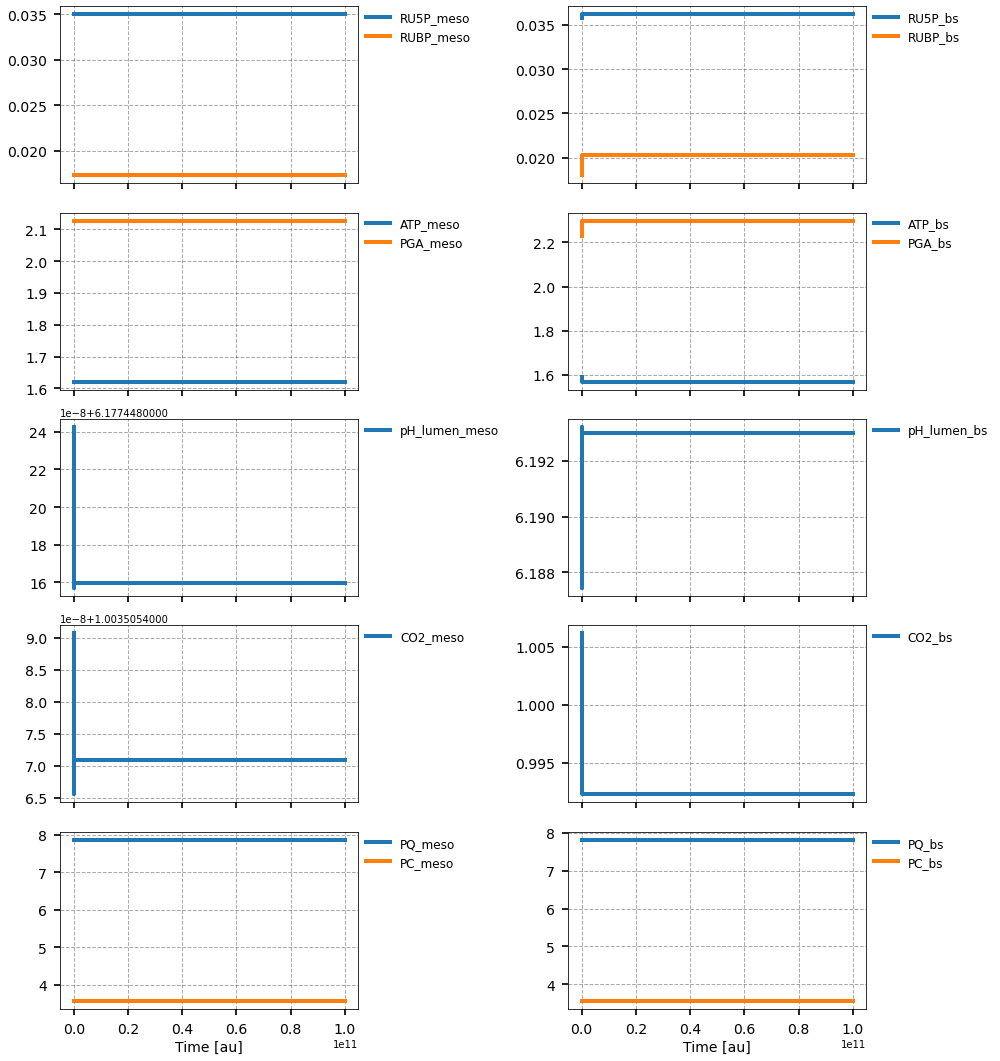

In [16]:
y0_ha = {
    "PGA_meso": 2.1273070929507707,
    "BPGA_meso": 0.0011515552571660845,
    "GAP_meso": 0.014425550972446358,
    "DHAP_meso": 0.3173620386436208,
    "FBP_meso": 0.03250465360113952,
    "F6P_meso": 1.4455882796134611,
    "G6P_meso": 3.3248530419882103,
    "G1P_meso": 0.1928414764070034,
    "SBP_meso": 0.138276120848401,
    "S7P_meso": 0.3731455822329854,
    "E4P_meso": 0.03351574837877381,
    "X5P_meso": 0.0522645674668104,
    "R5P_meso": 0.0875431468608635,
    "RUBP_meso": 0.017316580308235144,
    "RU5P_meso": 0.03501725812374217,
    "PQ_meso": 7.8640530572175695,
    "PC_meso": 3.567998396976726,
    "Fd_meso": 1.8653234810243102,
    "ATP_meso": 1.6214427058726313,
    "NADPH_meso": 0.6711856667704077,
    "H_lumen_meso": 0.002658347483945302,
    "LHC_meso": 0.6919818208345092,
    "Psbs_meso": 0.935743613553094,
    "Vx_meso": 0.8865353493165569,
    "TR_ox_meso": 0.711007185258015,
    "E_inactive_meso": 1.5424449430974039,
    "MDA_meso": 0.00010272741095088805,
    "DHA_meso": 2.6230017605306354e-06,
    "GSSG_meso": 1.2725278293448827e-06,
    "GLYC_meso": 0.014155713721113785,
    "GLYX_meso": 0.2145567679541931,
    "GLY_meso": 0.11160302259249698,
    "SER_meso": 0.0024180879615855453,
    "HPA_meso": 6.406067388998322e-06,
    "H2O2_meso": 5.701171470562867e-05,
    "2PG_meso": 3.6323374520896337e-06,
    "GLYA_meso": 1.0331732411535593e-05,
    "CO2_meso": 1.0035054907030543,
    "HCO3_meso": 50.17527453515271,
    "2PG_bs": 3.7113656305615716e-06,
    "ATP_bs": 1.5874832946823296,
    "BPGA_bs": 0.0011395172052077467,
    "CO2_bs": 1.0061496713328126,
    "DHAP_bs": 0.31631492077112,
    "DHA_bs": 2.748904386827913e-06,
    "E4P_bs": 0.03247522204994007,
    "E_inactive_bs": 1.5227432839282595,
    "F6P_bs": 1.4343838296513163,
    "FBP_bs": 0.03229051286383568,
    "Fd_bs": 1.8290228380069415,
    "G1P_bs": 0.19134680278075583,
    "G6P_bs": 3.299082807059686,
    "GAP_bs": 0.014377954709746696,
    "GLYA_bs": 0.004954584293529197,
    "GLYC_bs": 0.014538274162980142,
    "GLYX_bs": 0.21956585389678882,
    "GLY_bs": 54.50404171650696,
    "GSSG_bs": 1.3335621272543602e-06,
    "H2O2_bs": 5.8284887694944407e-05,
    "HCO3_bs": 50.307483566640634,
    "HPA_bs": 0.003014225861566238,
    "H_lumen_bs": 0.0025962760706543476,
    "LHC_bs": 0.6898134477022948,
    "MDA_bs": 0.00010516387564148313,
    "NADPH_bs": 0.6763120766926259,
    "PC_bs": 3.5654905892778106,
    "PGA_bs": 2.2287343471827548,
    "PQ_bs": 7.816317812545367,
    "Psbs_bs": 0.9396093683259342,
    "R5P_bs": 0.08935202710234019,
    "RU5P_bs": 0.03574081022027737,
    "RUBP_bs": 0.018002483554731885,
    "S7P_bs": 0.3900121249541491,
    "SBP_bs": 0.13354114459535915,
    "SER_bs": 1.308151296472057,
    "TR_ox_bs": 0.7059742923625545,
    "Vx_bs": 0.8977559186623528,
    "X5P_bs": 0.053344495969379166,
    "hydroxyaspartate_meso": 0.02280493697321796,
    "iminoaspartate_meso": 0.018243949580630022,
    "oxaloacetate_meso": 0.018243949578060453,
    "malate_bs": 0.0717906233852607,
    "pyruvate_bs": 1.622461688941326e-11,
    "PEP_bs": 5.775515482375276e-09,
    "NADH_bs": 9.86305059430202e-24,
    "NAD_bs": -2.591993672235984e-32,
}


m = models.get_hydroxyaspartate_shunt()
m.update_parameters(SHARED_PAR_UPDATES)
m.update_parameters(
    {
        #         "vmax_glycolate_oxidase": m.parameters["vmax_glycolate_oxidase"] * 10,
        "kf_malic_enzyme": m.parameters["kf_malic_enzyme"] * 100,
        "kf_malate_dehydrogenase": m.parameters["kf_malate_dehydrogenase"] / 100,
    },
)

s = Simulator(m)
s.initialise(y0_ha)
t, y = s.simulate(100_000_000_000)
v = s.get_fluxes_df()
c = s.get_full_results_df()
base_groups = [["RU5P", "RUBP"], ["ATP", "PGA"], ["pH_lumen"], ["CO2"], ["PQ", "PC"]]
groups = compartmentalise_groups(base_groups)

fig, axs = s.plot_grid(
    groups,
    ncols=2,
    sharex=True,
    sharey=False,
    xlabels="Time [au]",
    ylabels="",
    legend_kwargs={
        "loc": "upper left",
        "bbox_to_anchor": (1.01, 1),
        "borderaxespad": 0,
    },
    figure_kwargs={"figsize": (14, len(groups) // 2 * 3)},
)
plt.show()

STEADY_STATE_CONCS_2C["hydroxyaspartate"] = dict(s.get_full_results_df().iloc[-1])
STEADY_STATE_FLUXES_2C["hydroxyaspartate"] = dict(s.get_fluxes_df().iloc[-1])

## Comparison

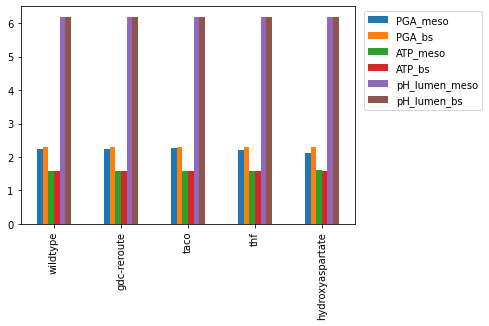

In [17]:
df = pd.DataFrame(STEADY_STATE_CONCS_2C).T
ax = df.loc[
    :, ["PGA_meso", "PGA_bs", "ATP_meso", "ATP_bs", "pH_lumen_meso", "pH_lumen_bs"]
].plot(kind="bar")
ax.legend(bbox_to_anchor=(1.01, 1))

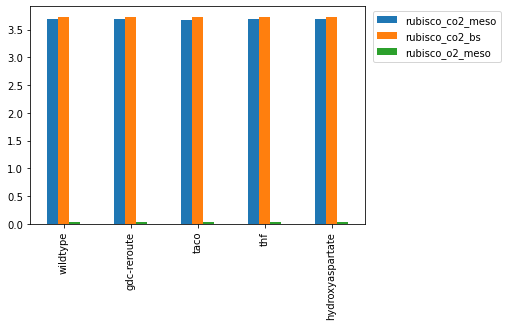

In [18]:
df = pd.DataFrame(STEADY_STATE_FLUXES_2C).T
ax = df.loc[:, ["rubisco_co2_meso", "rubisco_co2_bs", "rubisco_o2_meso"]].plot(kind="bar")
ax.legend(bbox_to_anchor=(1.01, 1))

In [19]:
def o2_scan(m, o2_values, y0):
    m.update_parameters(SHARED_PAR_UPDATES)  # TODO: remove me
    s = Simulator(m)
    conc = {}
    flux = {}
    for o2 in tqdm(o2_values, total=len(o2_values)):
        s.initialise(y0)
        s.update_parameter("O2", o2)
        try:
            t, y = s.simulate(100_000)
            conc[o2] = dict(s.get_full_results_df().iloc[-1])
            flux[o2] = dict(s.model.get_fluxes_df(y[-1]).iloc[-1])
            y0 = get_new_y0(s)
        except:
            break
        s.clear_results()
    return pd.DataFrame(conc).T, pd.DataFrame(flux).T


o2_values = np.linspace(0.01, 0.25, 10)

c_wt, v_wt = o2_scan(models.get_two_compartment_model(), o2_values, y0_2c)
c_taco, v_taco = o2_scan(models.get_taco_shunt(), o2_values, y0_taco)
c_ha, v_ha = o2_scan(models.get_hydroxyaspartate_shunt(), o2_values, y0_ha)
c_gdc, v_gdc = o2_scan(models.get_gdc_reroute(), o2_values, y0_gdc)
c_thf, v_thf = o2_scan(models.get_thf_bypass(), o2_values, y0_thf)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

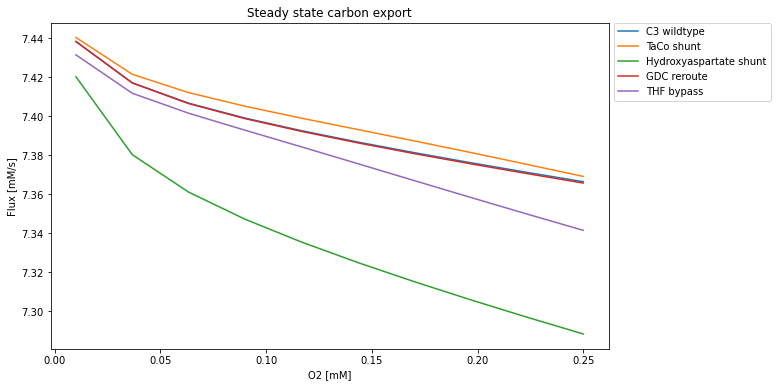

In [20]:
def carbon_utilization(v):
    return (
        v["GAP_out_meso"] * 3
        + v["PGA_out_meso"] * 3
        + v["DHAP_out_meso"] * 3
        + v["starch_production_meso"] * 6
        + v["GAP_out_bs"] * 3
        + v["PGA_out_bs"] * 3
        + v["DHAP_out_bs"] * 3
        + v["starch_production_bs"] * 6
    )


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(carbon_utilization(v_wt), color="C0", label="C3 wildtype")
ax.plot(carbon_utilization(v_taco), color="C1", label="TaCo shunt")
ax.plot(carbon_utilization(v_ha), color="C2", label="Hydroxyaspartate shunt")
ax.plot(carbon_utilization(v_gdc), color="C3", label="GDC reroute")
ax.plot(carbon_utilization(v_thf), color="C4", label="THF bypass")
ax.set(title="Steady state carbon export", xlabel="O2 [mM]", ylabel="Flux [mM/s]")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.show()